# Project 2: Mini deep-learning framework

In [22]:
import matplotlib.pyplot as plt #To remove (use matplotlib)
from torch import empty
import numpy as np
import math
import torch.nn as nn

from torch.autograd import Variable
from torch.nn import functional as F
import torch
torch.set_grad_enabled(False)

## Data generation

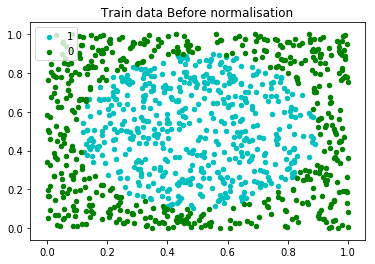

Point outside:  498
Point inside:   502


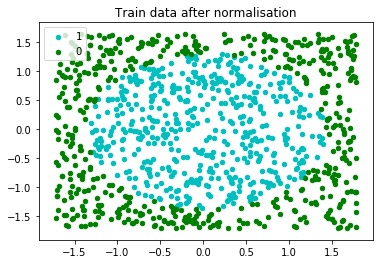

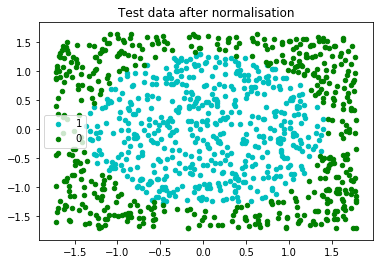

In [2]:
def generate_disc_set(nb):
    X = empty(nb,2).uniform_(0,1)
    Y = ( (X - 0.5).norm(dim=1)  <=  math.sqrt(1/(2*math.pi)) ).type(torch.LongTensor)
    return(X, Y)


train_input, train_target = generate_disc_set(1000)
test_input, test_target = generate_disc_set(1000)



plt.scatter(train_input[(train_target==1),0] ,train_input[(train_target==1),1], color = "c", s=20)
plt.scatter(train_input[(train_target==0),0] ,train_input[(train_target==0),1], color = "g", s=20)
plt.title("Train data Before normalisation")
plt.legend(["1", "0"] )
plt.show()

print("Point outside: ", train_input[(train_target==0),0].size(0))
print("Point inside:  ", train_input[(train_target==1),0].size(0))


mu, std = train_input.mean(0), train_input.std(0)
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)

plt.scatter(train_input[(train_target==1),0] ,train_input[(train_target==1),1], color = "c", s=20)
plt.scatter(train_input[(train_target==0),0] ,train_input[(train_target==0),1], color = "g", s=20)
plt.title("Train data after normalisation")
plt.legend(["1", "0"] )
plt.show()

plt.scatter(test_input[(test_target==1),0] ,test_input[(test_target==1),1], color = "c", s=20)
plt.scatter(test_input[(test_target==0),0] ,test_input[(test_target==0),1], color = "g", s=20)
plt.title("Test data after normalisation")
plt.legend(["1", "0"] )
plt.show()


## Classic Structure

In [3]:
class Module( object ):
    def forward( self , *input ):
        raise NotImplementedError

    def backward ( self , *gradwrtoutput ):
        raise NotImplementedError

    def param ( self ) :
        return []

## Non linearity

In [4]:
class Tanh():
    
    s = empty((0,0))
    
    def forward( self , x ):
        self.s = x
        return torch.tanh(x)

    def backward ( self , *gradwrtoutput ):
        return (1 - torch.pow(torch.tanh(self.s),2)) * (gradwrtoutput[0])
        #raise NotImplementedError
        
    def param ( self ) :
        return []
    
class Relu():
    
    s = empty((0,0))
    
    def forward(self , x ):
        self.s = x
        y = empty(x.size())
        y[x<=0] = 0
        y[x>0] = x[x>0]
        return y

    def backward ( self , *gradwrtoutput ):
        return gradwrtoutput[0]
        #raise NotImplementedError

    def param ( self ) :
        return []

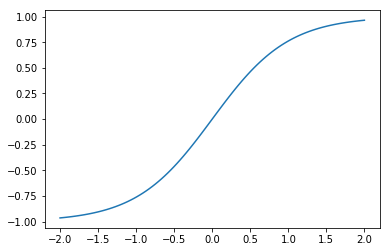

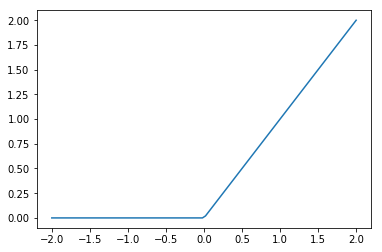

In [5]:
x = torch.linspace(-2,2,100)


tanh_1 = Tanh()
y_tan = tanh_1.forward(x)
plt.plot(x.numpy(), y_tan.numpy())
plt.show()

relu_1 = Relu()
y_relu = relu_1.forward(x)
grad = relu_1.backward(y_relu)
# print(grad)                          
plt.plot(x.numpy(), y_relu.numpy())
plt.show()




## Loss

In [49]:
class LossMSE():
    
    output = empty((0,0))
    target_output = empty((0,0))
    
    def forward( self , output, target_output ):
        self.output = output
        self.target_output = target_output
        loss = (output - target_output).pow(2).mean()
        return loss
        #raise NotImplementedError

    def backward ( self ):
        return 2*(self.output - self.target_output)/self.output.numel()

    def param ( self ) :
        return []

## Linear

In [50]:
class Linear():
    
    def __init__(self, weight_size, bias_size):
        self.bias = empty(bias_size)
        self.weight = empty(weight_size)
        
    def forward( self , *input ):
        raise NotImplementedError

    def backward ( self , *gradwrtoutput ):
        raise NotImplementedError

    def param ( self ) :
        return []

In [51]:
a = Linear((10,10), (4,4))
print(a.bias)

tensor([[1.3830e-08, 3.0861e-41, 1.4013e-45, 0.0000e+00],
        [1.9478e-08, 3.0861e-41, 1.4013e-45, 0.0000e+00],
        [1.4669e-08, 3.0861e-41, 0.0000e+00, 0.0000e+00],
        [1.5332e+29, 2.9158e-12, 1.3028e+01, 4.5884e-41]])


## Test

In [52]:
x = torch.linspace(-2,2,100)
target = torch.zeros(x.size())

relu_1 = Relu()
loss = LossMSE()

y_relu = loss.forward((relu_1.forward(x)), target)
grad = relu_1.backward(loss.backward())

torch.set_grad_enabled(True)
x = Variable(x.data, requires_grad=True)
class Net(nn.Module):
    def forward(self, x):
        x = F.relu(x)
        return x
model, criterion = Net(), nn.MSELoss()

true_output = model(x)
true_loss = criterion(true_output, target)

model.zero_grad()
#true_loss.backward()
print(torch.autograd.grad(true_loss, x)[0])
torch.set_grad_enabled(False)


print(grad)                          

print(true_loss)
print(y_relu)


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0004, 0.0012, 0.0020, 0.0028,
        0.0036, 0.0044, 0.0053, 0.0061, 0.0069, 0.0077, 0.0085, 0.0093, 0.0101,
        0.0109, 0.0117, 0.0125, 0.0133, 0.0141, 0.0149, 0.0158, 0.0166, 0.0174,
        0.0182, 0.0190, 0.0198, 0.0206, 0.0214, 0.0222, 0.0230, 0.0238, 0.0246,
        0.0255, 0.0263, 0.0271, 0.0279, 0.0287, 0.0295, 0.0303, 0.0311, 0.0319,
        0.0327, 0.0335, 0.0343, 0.0352, 0.0360, 0.0368, 0.0376, 0.0384, 0.0392,
        0.0400])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000,